In [1]:
import pandas as pd
import os
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.optimize import minimize
import copy

from experiment_params import *
from cost_funcs import *
from fl_sim_classes import *
import time
import pickle
from sklearn.decomposition import PCA

In [2]:
path = r'C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data'
cond0_filename = r'\cond0_dict_list.p'
all_decs_init_filename = r'\all_decs_init.p'
nofl_decs_filename = r'\nofl_decs.p'
id2color = {0:'lightcoral', 1:'maroon', 2:'chocolate', 3:'darkorange', 4:'gold', 5:'olive', 6:'olivedrab', 
            7:'lawngreen', 8:'aquamarine', 9:'deepskyblue', 10:'steelblue', 11:'violet', 12:'darkorchid', 13:'deeppink'}
implemented_client_training_methods = ['EtaGradStep', 'EtaScipyMinStep', 'FullScipyMinStep']
implement_these_methods_next = ['APFL', 'AFL', 'PersA_FL_MAML', 'PersA_FL_ME', 'PFA']
num_participants = 14

# For exclusion when plotting later on
bad_nodes = [1,3,13]

with open(path+cond0_filename, 'rb') as fp:
    cond0_training_and_labels_lst = pickle.load(fp)

D_0_7 = np.random.rand(2,7)

## Load in a Dataset

In [3]:
#iris = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/iris.csv')
#iris.head()

In [4]:
#plt.scatter(iris.iloc[:,0], iris.iloc[:,3])

In [5]:
#data = iris[['sepal_length', 'petal_width' ]]
#data.head()

In [6]:
#X = pd.DataFrame(data.iloc[:, 0])
## Add a columns of 1s as intercept to X
#X['intercept'] = 1
#y = data.iloc[:, 1]
#m = len(y)
#theta = np.array([0, 0])

In [7]:
#iterations = 1500
#alpha = 0.01

In [8]:
def iris_cost_func(X, y, theta):
    """
    cost_function(X, y, theta) computes the cost of using theta as the
    parameter for linear regression to fit the data points in X and y
    """
    ## number of training examples
    m = len(y) 
    
    ## Calculate the cost with the given parameters
    J = np.sum((X.dot(theta)-y)**2)/2/m
    
    return J

In [9]:
#iris_cost_function(X, y, theta)

In [10]:
#cost_history = [0] * iterations
#gradient_history = [0] * iterations

#for i in range(iterations):
#    hypothesis = X.dot(theta)
#    loss = hypothesis-y
#    gradient = X.T.dot(loss)/m
#    theta = theta - alpha*gradient
#    cost = cost_function(X, y, theta)#
#
#    cost_history[i] = cost
#    gradient_history[i] = gradient

In [11]:
def gradient_descent(X, y, theta, alpha, iterations):
    """
    gradient_descent Performs gradient descent to learn theta
    theta = GRADIENTDESENT(X, y, theta, alpha, num_iters) updates theta by 
    taking num_iters gradient steps with learning rate alpha
    """
    cost_history = [0] * iterations
    gradient_history = [0] * iterations
    
    for iteration in range(iterations):
        hypothesis = X.dot(theta)
        loss = hypothesis-y
        gradient = X.T.dot(loss)/m
        theta = theta - alpha*gradient
        cost = cost_function(X, y, theta)
        
        cost_history[iteration] = cost
        gradient_history[iteration] = gradient

    return theta, cost_history, gradient_history

In [12]:
#(t, c, g) = gradient_descent(X,y,theta,alpha, iterations)
#x_axis = list(range(iterations))
#plt.plot(x_axis, c)
#plt.show()

In [13]:
#plt.plot(x_axis, g)
#plt.show()

In [14]:
def gd(X, y, theta, alpha, iterations):
    #KAI'S MATRIX VERSION
    """
    gradient_descent Performs gradient descent to learn theta
    theta = GRADIENTDESENT(X, y, theta, alpha, num_iters) updates theta by 
    taking num_iters gradient steps with learning rate alpha
    """
    cost_history = [0] * iterations
    gradient_history = [0] * iterations
    
    for i in range(iterations):
        hypothesis = X@theta
        loss = hypothesis-y
        gradient = X.T@loss/m
        theta = theta - alpha*gradient
        cost = cost_function(X, y, theta)
        cost_history[i] = cost
        gradient_history[i] = gradient

    return theta, cost_history, gradient_history

In [15]:
print(cond0_training_and_labels_lst[0]['training'].shape)
print(cond0_training_and_labels_lst[0]['training'][update_ix[11]:update_ix[12]].shape)
print(cond0_training_and_labels_lst[0]['labels'][update_ix[11]:update_ix[12]].shape)

(20770, 64)
(1202, 64)
(1202, 2)


In [16]:
# NOW DO PURE GD
my_lr = 0.001
my_iters = 500
#pca = PCA(n_components=7)
dt = 1.0/60.0

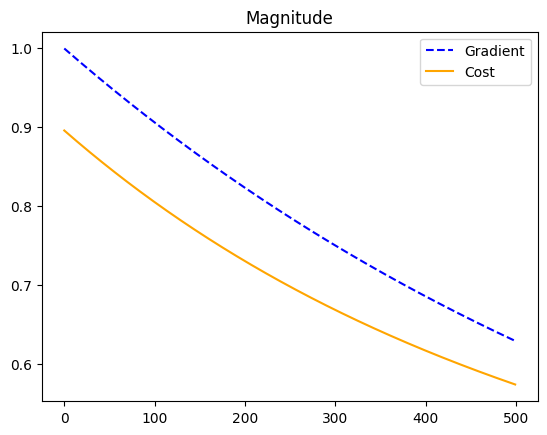

In [17]:
single_gradient = [0]*my_iters
single_cost = [0]*my_iters

s_temp = cond0_training_and_labels_lst[10]['training'][update_ix[11]:update_ix[12]]
pca = PCA(n_components=7)
s_temp = pca.fit_transform(s_temp)
s = np.transpose(s_temp)

D = D_0_7
v_actual = D@s
p_actual = np.cumsum(v_actual, axis=1)*dt

p_reference = np.transpose(cond0_training_and_labels_lst[10]['labels'][update_ix[11]:update_ix[12]])

F = s[:,:-1]
V = (p_reference - p_actual)*dt

#Vglobal = (p_reference - np.cumsum(self.global_w@s, axis=1)*self.dt)*self.dt
#Vlocal = (p_reference - np.cumsum(self.local_w@s, axis=1)*self.dt)*self.dt

my_gradient = [0]*my_iters
my_cost = [0]*my_iters

for i in range(my_iters):
    my_grad = gradient_cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
    single_gradient[i] = np.linalg.norm(my_grad)
    single_cost[i] = cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
    D -= my_lr * np.reshape(my_grad, (2, 7))

x_axis = list(range(my_iters))
plt.plot(x_axis, single_gradient, color='blue', linestyle='--', label='Gradient')
plt.plot(x_axis, single_cost, color='orange', label='Cost')
plt.title('Magnitude')
plt.legend()
plt.show()

## All Users

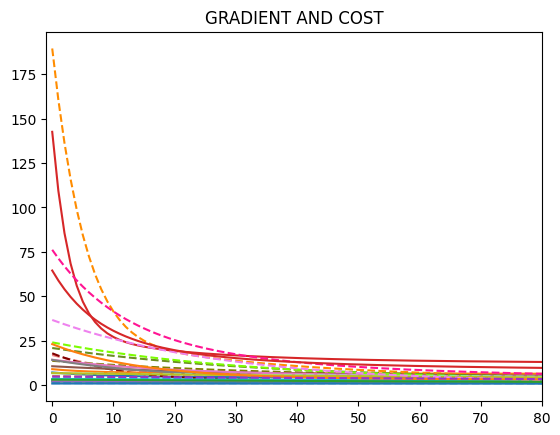

In [18]:
my_gradient = [[0]*my_iters for _ in range(14)]
my_cost = [[0]*my_iters for _ in range(14)]
final_decs = [0]*14

for user_idx in range(14):
    s_temp = cond0_training_and_labels_lst[user_idx]['training'][update_ix[11]:update_ix[12]]
    pca = PCA(n_components=7)
    s_temp = pca.fit_transform(s_temp)
    s = np.transpose(s_temp)

    D = np.random.rand(2,7)
    v_actual = D@s
    p_actual = np.cumsum(v_actual, axis=1)*dt

    p_reference = np.transpose(cond0_training_and_labels_lst[user_idx]['labels'][update_ix[11]:update_ix[12]])

    F = s[:,:-1]
    V = (p_reference - p_actual)*dt

    #Vglobal = (p_reference - np.cumsum(self.global_w@s, axis=1)*self.dt)*self.dt
    #Vlocal = (p_reference - np.cumsum(self.local_w@s, axis=1)*self.dt)*self.dt
    
    for i in range(my_iters):
        my_grad = gradient_cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
        my_gradient[user_idx][i] = np.linalg.norm(my_grad)
        my_cost[user_idx][i] = cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
        D -= my_lr * np.reshape(my_grad, (2, 7))
    final_decs[user_idx] = D

x_axis = list(range(my_iters))
for i in range(len(my_gradient)):
    plt.plot(x_axis, my_gradient[i], color=id2color[i], linestyle="--", label=f"C{i} Gradient")
    plt.plot(x_axis, my_cost[i], label=f"C{i} Cost")
plt.title('GRADIENT AND COST')
plt.xlim(-1, 80)
#plt.legend(loc='below')  # Below DNE...
plt.show()

## Redoing the same as above to validate results are the same on repeat

In [19]:
np.random.seed(0)

[[0.75053665 0.99802279 0.53397792 0.94420272 0.39661011 0.10668245
  0.40877383]
 [0.29612777 0.49340696 0.65704368 0.46105022 0.93516051 0.88476482
  0.7019776 ]]

[[0.55156996 0.12301676 0.81827277 0.49736312 0.23438295 0.59275958
  0.79325931]
 [0.32762435 0.70147632 0.42785918 0.96405117 0.77094009 0.3563509
  0.01774796]]

[[0.41005152 0.15641675 0.52204825 0.26266441 0.63359344 0.39860618
  0.85372103]
 [0.77136259 0.14793323 0.59109196 0.71374062 0.51444091 0.11394728
  0.50324739]]

[[0.71714763 0.06124965 0.36731862 0.2062302  0.51879518 0.77210243
  0.12992487]
 [0.98673446 0.46711171 0.77301669 0.35241635 0.48813678 0.96486424
  0.69026216]]

[[0.73603218 0.4766677  0.2723102  0.82209302 0.82911489 0.55064789
  0.60156   ]
 [0.51353417 0.78213733 0.8870782  0.00201192 0.973627   0.34412074
  0.39912734]]

[[0.70992859 0.52084103 0.85950839 0.66079679 0.49349551 0.84211326
  0.58432055]
 [0.07600243 0.80260811 0.84559034 0.0480761  0.77041587 0.98085887
  0.79073311]]

[[0.9

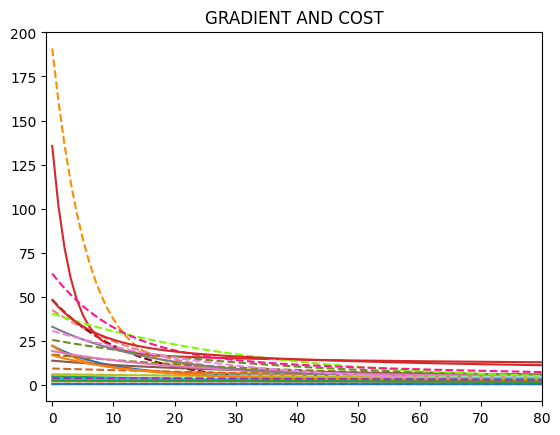

In [20]:
my_gradient = [[0]*my_iters for _ in range(14)]
my_cost = [[0]*my_iters for _ in range(14)]
final_decs = [0]*14

for user_idx in range(14):
    s_temp = cond0_training_and_labels_lst[user_idx]['training'][update_ix[11]:update_ix[12]]
    pca = PCA(n_components=7)
    s_temp = pca.fit_transform(s_temp)
    s = np.transpose(s_temp)

    D = np.random.rand(2,7)
    print(D)
    print()
    v_actual = D@s
    p_actual = np.cumsum(v_actual, axis=1)*dt

    p_reference = np.transpose(cond0_training_and_labels_lst[user_idx]['labels'][update_ix[11]:update_ix[12]])

    F = s[:,:-1]
    V = (p_reference - p_actual)*dt

    for i in range(my_iters):
        my_grad = gradient_cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
        my_gradient[user_idx][i] = np.linalg.norm(my_grad)
        my_cost[user_idx][i] = cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
        D -= my_lr * np.reshape(my_grad, (2, 7))
    final_decs[user_idx] = D
    
x_axis = list(range(my_iters))
for i in range(len(my_gradient)):
    plt.plot(x_axis, my_gradient[i], color=id2color[i], linestyle="--", label="Gradient")
    plt.plot(x_axis, my_cost[i], label="Cost")
plt.title('GRADIENT AND COST')
plt.xlim(-1, 80)
plt.show()

## Redoing the same as above to validate results are the same on repeat, this time setting to the same seed

In [21]:
np.random.seed(0)

[[0.75053665 0.99802279 0.53397792 0.94420272 0.39661011 0.10668245
  0.40877383]
 [0.29612777 0.49340696 0.65704368 0.46105022 0.93516051 0.88476482
  0.7019776 ]]

[[0.55156996 0.12301676 0.81827277 0.49736312 0.23438295 0.59275958
  0.79325931]
 [0.32762435 0.70147632 0.42785918 0.96405117 0.77094009 0.3563509
  0.01774796]]

[[0.41005152 0.15641675 0.52204825 0.26266441 0.63359344 0.39860618
  0.85372103]
 [0.77136259 0.14793323 0.59109196 0.71374062 0.51444091 0.11394728
  0.50324739]]

[[0.71714763 0.06124965 0.36731862 0.2062302  0.51879518 0.77210243
  0.12992487]
 [0.98673446 0.46711171 0.77301669 0.35241635 0.48813678 0.96486424
  0.69026216]]

[[0.73603218 0.4766677  0.2723102  0.82209302 0.82911489 0.55064789
  0.60156   ]
 [0.51353417 0.78213733 0.8870782  0.00201192 0.973627   0.34412074
  0.39912734]]

[[0.70992859 0.52084103 0.85950839 0.66079679 0.49349551 0.84211326
  0.58432055]
 [0.07600243 0.80260811 0.84559034 0.0480761  0.77041587 0.98085887
  0.79073311]]

[[0.9

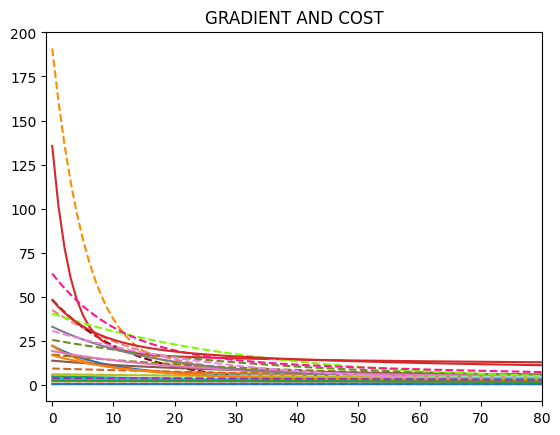

In [22]:
my_gradient = [[0]*my_iters for _ in range(14)]
my_cost = [[0]*my_iters for _ in range(14)]
final_decs = [0]*14

for user_idx in range(14):
    s_temp = cond0_training_and_labels_lst[user_idx]['training'][update_ix[11]:update_ix[12]]
    pca = PCA(n_components=7)
    s_temp = pca.fit_transform(s_temp)
    s = np.transpose(s_temp)

    D = np.random.rand(2,7)
    print(D)
    print()
    v_actual = D@s
    p_actual = np.cumsum(v_actual, axis=1)*dt

    p_reference = np.transpose(cond0_training_and_labels_lst[user_idx]['labels'][update_ix[11]:update_ix[12]])

    F = s[:,:-1]
    V = (p_reference - p_actual)*dt

    for i in range(my_iters):
        my_grad = gradient_cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
        my_gradient[user_idx][i] = np.linalg.norm(my_grad)
        my_cost[user_idx][i] = cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
        D -= my_lr * np.reshape(my_grad, (2, 7))
    final_decs[user_idx] = D
    
x_axis = list(range(my_iters))
for i in range(len(my_gradient)):
    plt.plot(x_axis, my_gradient[i], color=id2color[i], linestyle="--", label="Gradient")
    plt.plot(x_axis, my_cost[i], label="Cost")
plt.title('GRADIENT AND COST')
plt.xlim(-1, 80)
plt.show()

## Setting D to the same init for each user
> This is the one that falls apart, as it picks it where the above left off.  Why?

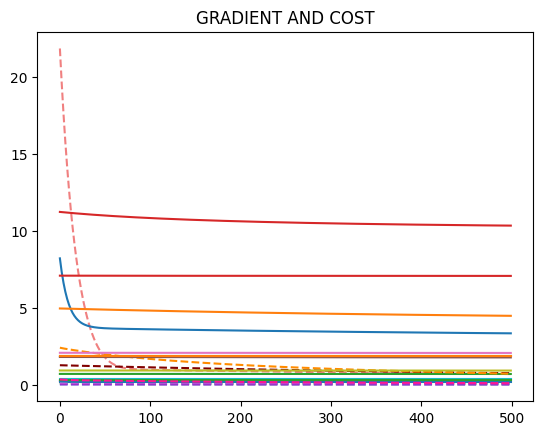

In [23]:
my_gradient = [[0]*my_iters for _ in range(14)]
my_cost = [[0]*my_iters for _ in range(14)]
final_decs = [0]*14

for user_idx in range(14):
    s_temp = cond0_training_and_labels_lst[user_idx]['training'][update_ix[11]:update_ix[12]]
    pca = PCA(n_components=7)
    s_temp = pca.fit_transform(s_temp)
    s = np.transpose(s_temp)

    D = D_0_7
    v_actual = D@s
    p_actual = np.cumsum(v_actual, axis=1)*dt

    p_reference = np.transpose(cond0_training_and_labels_lst[user_idx]['labels'][update_ix[11]:update_ix[12]])

    F = s[:,:-1]
    V = (p_reference - p_actual)*dt

    for i in range(my_iters):
        my_grad = gradient_cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
        my_gradient[user_idx][i] = np.linalg.norm(my_grad)
        my_cost[user_idx][i] = cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
        D -= my_lr * np.reshape(my_grad, (2, 7))
    final_decs[user_idx] = D
    
x_axis = list(range(my_iters))
for i in range(len(my_gradient)):
    plt.plot(x_axis, my_gradient[i], color=id2color[i], linestyle="--", label="Gradient")
    plt.plot(x_axis, my_cost[i], label="Cost")
plt.title('GRADIENT AND COST')
plt.show()

Clearly, we see that the gradient breaks for some reason, AFAIK it is completely controlled by whether or not D is reset between users.  I'm not sure why that would be

## Single
> Continuation of the above trend but for a single user

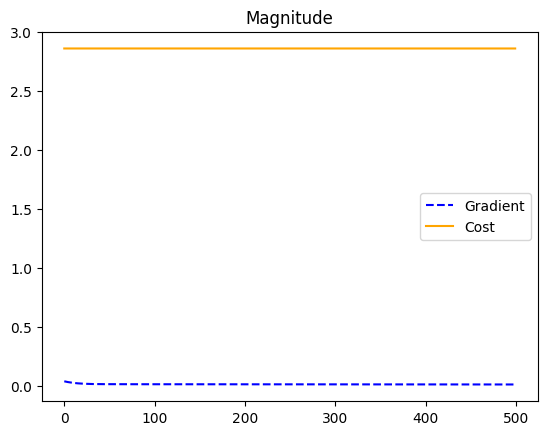

In [24]:
single_gradient = [0]*my_iters
single_cost = [0]*my_iters

s_temp = cond0_training_and_labels_lst[0]['training'][update_ix[11]:update_ix[12]]
s_temp = pca.fit_transform(s_temp)
s = np.transpose(s_temp)

D = D_0_7
v_actual = D@s
p_actual = np.cumsum(v_actual, axis=1)*dt

p_reference = np.transpose(cond0_training_and_labels_lst[0]['labels'][update_ix[11]:update_ix[12]])

F = s[:,:-1]
V = (p_reference - p_actual)*dt

#Vglobal = (p_reference - np.cumsum(self.global_w@s, axis=1)*self.dt)*self.dt
#Vlocal = (p_reference - np.cumsum(self.local_w@s, axis=1)*self.dt)*self.dt

my_gradient = [0]*my_iters
my_cost = [0]*my_iters

for i in range(my_iters):
    my_grad = gradient_cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
    single_gradient[i] = np.linalg.norm(my_grad)
    single_cost[i] = cost_l2(F, D, np.zeros((2,2)), V, len(s_temp), 1e-7, 1e-3, Ne=7)
    D -= my_lr * np.reshape(my_grad, (2, 7))

x_axis = list(range(my_iters))
plt.plot(x_axis, single_gradient, color='blue', linestyle='--', label='Gradient')
plt.plot(x_axis, single_cost, color='orange', label='Cost')
plt.title('Magnitude')
plt.legend()
plt.show()

In [25]:
assert(1==0)

AssertionError: 

In [ ]:
dt = 1.0/60.0

s_temp = cond0_training_and_labels_lst[0]['training'][update_ix[11]:update_ix[12]]
if self.PCA_comps!=self.pca_channel_default:  
    pca = PCA(n_components=self.PCA_comps)
    s_temp = pca.fit_transform(s_temp)
s = np.transpose(s_temp)

v_actual = D@s
p_actual = np.cumsum(v_actual, axis=1)*dt

p_reference = np.transpose(cond0_training_and_labels_lst[0]['labels'][update_ix[11]:update_ix[12]])

F = s[:,:-1]
V = (p_reference - p_actual)*dt

Vglobal = (np.transpose(self.labels[lower_bound:upper_bound,:]) - np.cumsum(self.global_w@s, axis=1)*self.dt)*self.dt
Vlocal = (np.transpose(self.labels[lower_bound:upper_bound,:]) - np.cumsum(self.local_w@s, axis=1)*self.dt)*self.dt

In [ ]:
t = self.current_global_round
eigvals, _ = np.linalg.eig(hessian_cost_l2(self.F, self.alphaD))
mu = np.amin(eigvals)  # Mu is the minimum eigvalue
if mu.imag < self.tol and mu.real < self.tol:
    mu = self.alphaD
elif mu.imag < self.tol:
    mu = mu.real
elif mu.real < self.tol:
    print("Setting to imaginary only")
    mu = mu.imag
L = np.amax(eigvals)  # L is the maximum eigvalue
if L.imag < self.tol and L.real < self.tol:
    raise ValueError("L is 0, thus implying func is not L-smooth")
elif mu.imag < self.tol:
    L = L.real
elif L.real < self.tol:
    print("Setting to imaginary only")
    L = L.imag
if self.verbose:
    print(f"ID: {self.ID}, L: {L}, mu: {mu}")
kappa = L/mu
a = np.max([128*kappa, self.tau])
eta_t = 16 / (mu*(t+a))
if self.input_eta:
    if self.safe_lr!=False:
        raise ValueError("Cannot input eta AND use safe learning rate (they overwrite each other)")
    eta_t = self.eta
elif self.safe_lr!=False:
    eta_t = 1/(self.safe_lr*L)
elif eta_t >= 1/(2*L):
    raise ValueError("Learning rate is too large according to constaints on GD")
if self.verbose:
    print(f"ID: {self.ID}, eta_t: {eta_t}")
    print()
self.p.append((t+a)**2)

if self.adaptive:
    self.adap_alpha.append(self.adap_alpha[-1] - eta_t*np.inner(np.reshape((self.local_w-self.global_w), (self.PCA_comps*2)), np.reshape(gradient_cost_l2(self.F, self.mixed_w, self.H, self.V, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps), (2*self.PCA_comps,))))

# GRADIENT DESCENT BASED MODEL UPDATE
# NOTE: eta_t IS DIFFERENT FROM CLIENT'S ETA (WHICH IS NOT USED)
# I think the grads really ought to be reshaping this automatically, not sure why it's not

global_gradient = np.reshape(gradient_cost_l2(self.F, self.global_w, self.H, self.Vglobal, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps), (2, self.PCA_comps))
local_gradient = np.reshape(gradient_cost_l2(self.F, self.mixed_w, self.H, self.Vlocal, self.learning_batch, self.alphaF, self.alphaD, Ne=self.PCA_comps), (2, self.PCA_comps))
# Gradient clipping
if self.gradient_clipping:
    if np.linalg.norm(global_gradient) > self.clipping_threshold:
        global_gradient = self.clipping_threshold*global_gradient/np.linalg.norm(global_gradient)
    if np.linalg.norm(local_gradient) > self.clipping_threshold:
        local_gradient = self.clipping_threshold*local_gradient/np.linalg.norm(local_gradient)

########################################
# Or should I normalize the dec here?  I'll also turn this on since idc about computational speed rn
#if self.normalize_dec:
#    self.global_w /= np.amax(self.global_w)
#    self.local_w /= np.amax(self.local_w)
#    self.mixed_w /= np.amax(self.mixed_w)
########################################

# PSEUDOCODE: my_client.global_w -= my_client.eta * grad(f_i(my_client.global_w; my_client.smallChi))
self.global_w -= eta_t * global_gradient
# PSEUDOCODE: my_client.local_w -= my_client.eta * grad_v(f_i(my_client.v_bar; my_client.smallChi))
self.local_w -= eta_t * local_gradient
self.mixed_w = self.adap_alpha[-1]*self.local_w - (1 - self.adap_alpha[-1])*self.global_w
########################################
# Or should I normalize the dec here?  I'll also turn this on since idc about computational speed rn
#if self.normalize_dec:
#    self.global_w /= np.amax(self.global_w)
#    self.local_w /= np.amax(self.local_w)
#    self.mixed_w /= np.amax(self.mixed_w)
########################################


In [ ]:
def cost_l2(F, D, H, V, learning_batch, alphaF, alphaD, alphaE=1e-6, Nd=2, Ne=64):
    Nt = learning_batch
    D = np.reshape(D,(Nd,Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    term1 = alphaE*(np.linalg.norm((D@F + H@Vminus - Vplus))**2)
    term2 = alphaD*(np.linalg.norm(D)**2)
    term3 = alphaF*(np.linalg.norm(F)**2)
    return (term1 + term2 + term3)
# This is the Error function used to compute the loss for SGD
def E(a,b,data):
    # E(a,b) = (y - (a*x +b))^2 
    x,y = data # x and y coordinates of the point
    return (y-(a*x+b))**2

In [ ]:
# This is the gradient of the Error function used to update the equation's coefficients (a and b) for SGD
def gradientE(a,b,data):
    # gradA = dE(a,b)/da = -2*x*(y-a*x+b)
    # gradB = dE(a,b)/db = -2*(y-a*x+b)
    x,y = data
    gradientA = -2*x*(y-(a*x+b))
    gradientB = -2*(y-(a*x+b))

    return np.array([gradientA,gradientB])
def gradient_cost_l2(F, D, H, V, learning_batch, alphaF, alphaD, alphaE=1e-6, Nd=2, Ne=64):
    Nt = learning_batch
    D = np.reshape(D,(Nd, Ne))
    Vplus = V[:,1:]
    Vminus = V[:,:-1]
    return ((2*(D@F + H@Vminus - Vplus)@F.T*(alphaE) + 2*alphaD*D ).flatten())

In [ ]:
# This is the stochastic gradient descent algorithm
def stochasticGradientDescent(E, gradientE, data, startingCoefficients, learningRate, nbIteration):
    
    coefHistory = [] # Used to save the value of a and b at each iteration
    lossHistory = [] # Used to save the value of the loss at each iteration
    gradientHistory = [] # Used to save the value of the gradient at each iteration
    X = startingCoefficients # This is a tuple (a,b) with a and b the starting coefficients
    
    for _ in range((int)(nbIteration/len(data))): # nbIterations/len(data) = number of epochs
        
        for i in range(len(data)): # len(data) iterations are made here
            
            loss = E(*X,data[i]) # Compute the loss for one data and the coefficients a and b
            grad = gradientE(*X,data[i]) # Compute the gradient for one data

            # Save the coefficients, loss and gradient of the current data in the lists
            coefHistory.append(X)
            lossHistory.append(loss)
            gradientHistory.append(grad)

            X = X-learningRate*grad # Update the coefficients a and b 
        
    return coefHistory, lossHistory, gradientHistory


# This is mini-batch stochastic gradient descent algorithm
def miniBatchSGD(E, gradientE, data, startingCoefficients, learningRate, nbEpoch, batchSize):
    
    coefHistory = [] # Used to save the value of a and b at each iteration
    lossHistory = [] # Used to save the value of the loss at each iteration
    gradientHistory = [] # Used to save the value of the gradient at each iteration
    X = startingCoefficients # This is a tuple (a,b) with a and b the starting coefficients
    
    for _ in range(nbEpoch): 
        
        for i in range((int)(np.ceil(len(data)/batchSize))): # Number of steps (iterations)
            batchData = data[i*batchSize:i*batchSize+batchSize] #Create the sublist that contains batchSize data       
            
            loss = MSE(*X,batchData) # Compute the loss thanks to the data and the coefficients a and b
            grad = gradientMSE(*X,batchData) # Compute the gradient 

            # Save the coefficients, loss and gradient of the current iteration (epoch) in the lists
            coefHistory.append(X)
            lossHistory.append(loss)
            gradientHistory.append(grad)

            X = X-learningRate*grad # Update the coefficients a and b 
        
    return coefHistory, lossHistory, gradientHistory

In [ ]:
user_c0_APFL_eta_m10 = [Client(i, D_0_7, 'NAN', cond0_training_and_labels_lst[i], 
                       'streaming', eta=1e-10, input_eta=True, gradient_clipping=True, adaptive=False, 
                       num_steps=10, global_method='APFL') for i in range(14)]

In [ ]:
gradient_descent(X, y, theta, alpha, iterations)

In [ ]:
stochasticGradientDescent(E, gradientE, data, startingCoefficients, learningRate, nbIteration)

In [ ]:
miniBatchSGD(E, gradientE, data, startingCoefficients, learningRate, nbEpoch, batchSize)